We apply the CMA-ES algorithm to train a recurrent neural network (RNN) to maximize the reward in the [BipedalWalker](https://www.gymlibrary.ml/environments/box2d/bipedal_walker/) environment. In the environment, a robot walks to the right of the terrain and earns a higher reward if it avoids falling and applies force efficiently. The robot is controlled by an RNN that chooses the actions taken by the robot based on its observations.

The [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES) algorithm is an evolutionary algorithm used to learn the weights of the RNN. As first, the algorithm generates random weights for the RNN with a multivariate normal distribution. It updates the mean of the distribution to be closer to the random policies that perform better. The CMA-ES also adapts the covariance matrix to control the width of the search to avoid being trapped in local minima. The CMA-ES gradually learns to sample weights closer and closer to the global minimum of the cost function. The CMA-ES also avoids calculating the derivative, which is required in backpropagation, the most common method of training neural networks.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from joblib import Parallel, delayed
import pickle
from datetime import datetime

from cmaes import CmaEs
from nn import NN, get_weights_size

In [2]:
%matplotlib inline

In [3]:
def rollout(policy, repeat_n=1, render=False):
    env = gym.make("BipedalWalker-v3")
    total_reward = 0
    for _ in range(repeat_n):
        predicted = np.zeros(policy.layer_sizes[-1])
        obs = env.reset()
        done = False
        while not done:
            predicted = policy.predict(np.concatenate((obs, predicted[4:])))
            obs, reward, done, _ = env.step(predicted[:4])
            total_reward += reward
            if render:
                env.render()
    return total_reward / repeat_n

In [4]:
def make_weighted_nn(layer_sizes, flatten_weights):
    nn = NN(layer_sizes=layer_sizes)
    nn.set_flatten_weights(flatten_weights)
    return nn

In [5]:
def save_cma(path, cma):
    with open(path, 'wb') as outp:
        pickle.dump(cma, outp, pickle.HIGHEST_PROTOCOL)

def read_cma(path):
    with open(path, 'rb') as inp:
        return pickle.load(inp)

As we use a RNN policy, the observation and the action are number arrays of size 24 and 4 resepectively.  the input and output of the neural network have 6 more units, which serve as the recurrent connections.

In [6]:
parallel_worker = 4
layer_sizes = [30, 30, 20, 10]
weights_size = get_weights_size(layer_sizes)
population_size = 128
mu = 32  # Selected population size
cma_path = None
best_policy_path = None
best_policy = None if best_policy_path is None \
    else np.load(best_policy_path)
best_score = -100000 if best_policy_path is None \
    else rollout(make_weighted_nn(layer_sizes, best_policy), 10)
repeat_n = 10

In [7]:
cma = CmaEs(np.zeros(weights_size), 0.1 * np.identity(weights_size), population_size, mu) \
  if cma_path is None \
    else read_cma(cma_path)
score_record = []
step_size_record = []
cond_num_record = []
score_above_300 = False

The CMA-ES runs until it finds a policy that achieve a reward over 305.

In [8]:
max_epoch = 1
for i in range(max_epoch):
    population = cma.sample()
    scores = Parallel(n_jobs=parallel_worker)(
        delayed(rollout)(
            make_weighted_nn(layer_sizes, population[i]),  
            repeat_n
        ) for i in range(cma.population_size)
    )
    scores = np.array(scores)
    score_record.append(scores)
    max_id = np.argmax(scores)
    if scores[max_id] > best_score:
        best_policy = population[max_id]
        best_score = scores[max_id]
    cma.update(population, -scores) # CMA performs minimization
    step_size_record.append(cma.step_size)
    cond_num_record.append(np.linalg.cond(cma.cov))
    if i and i % 100:
        save_cma(f'fixtures/normal/cma/{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', cma)
        np.save(f'fixtures/normal/policy/{datetime.now().strftime("%Y%m%d%H%M%S")}', best_policy)
    if best_score > 305 and score_above_300:
        break

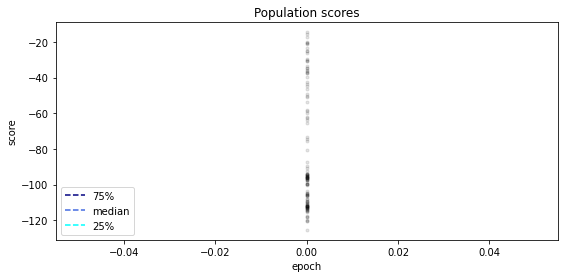

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.plot(score_record , '.', color='black', alpha=0.1);
ax.plot([np.percentile(a, 75) for a in score_record], '--', color='navy', label='75%');
ax.plot([np.percentile(a, 50) for a in score_record], '--', color='royalblue', label='median')
ax.plot([np.percentile(a, 25) for a in score_record], '--', color='aqua', label='25%');
ax.legend(loc='lower left')
ax.set(ylabel='score', xlabel='epoch', title='Population scores');

In [10]:
print(f'Best score is {best_score:.2f}')


Best score is -14.65


We can check the covergence status of the CMA-ES algorithm by chceking te condition number of the covariance matrix, and step size of the algorithm.

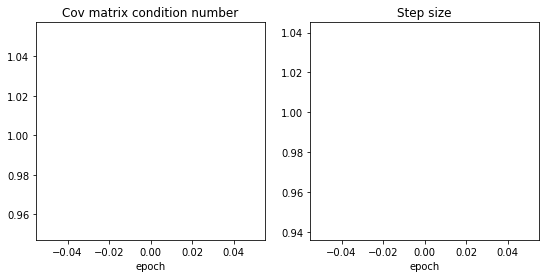

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(cond_num_record)
ax[1].plot(step_size_record)
ax[0].set(title='Cov matrix condition number', xlabel='epoch')
ax[1].set(title='Step size', xlabel='epoch')
ax[0].set(title='Cov matrix condition number', xlabel='epoch')
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'));

In [ ]:
save_cma(f'fixtures/normal/cma/{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', cma)
save_cma('fixtures/normal/cma/final.pkl', cma)

In [ ]:
np.save(f'fixtures/normal/policy/{datetime.now().strftime("%Y%m%d%H%M%S")}', best_policy)
np.save(f'fixtures/normal/policy/final}', best_policy)